# Predict media from taxa

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import umap

import os
DATA_DIR = "~/Desktop/code/data/"

Load and format model input

In [2]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "ec-taxa-media-overlap.csv"), low_memory=False)

# Remove "non-specific" EC numbers (e.g., 1.1.-.-, 1.1.1.-)
filter = data_df["ec"].str.contains("-")
data_df = data_df[~filter]

# Calculate counts and pivot, fillna with zeroes
data_df = data_df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
data_df = data_df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
data_df = data_df.fillna(0.0).reset_index()

data_df.head()

ec,taxon_id,media_id,1.1.1.1,1.1.1.103,1.1.1.11,1.1.1.119,1.1.1.14,1.1.1.18,1.1.1.2,1.1.1.22,...,3.5.2.10,3.5.2.6,3.5.3.1,3.5.3.3,3.5.5.1,4.1.1.73,4.2.1.32,4.4.1.1,6.2.1.57,6.3.1.20
0,1004166,1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1004261,J181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004261,J455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005925,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005926,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

In [3]:
TARGET_VAR = "taxon_id"
RANDOM_SEED = 666
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

### Splitting

Splitting input into training (80%) and test (20%) sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

Uniform Manifold Approximation and Projection (UMAP) to reduce feature dimensionality

In [6]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=3, 
    n_epochs=500, # can increase, this is recommended on UMAP documentation
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

,Component 1,Component 2,Component 3
0,15.552606,11.062140,-5.814806
1,0.684297,22.511497,9.303279
2,16.807875,-9.751039,2.702453
3,7.432455,9.199549,21.868313
4,19.662439,11.384926,14.668433


### Clustering

Elbow and silhouette methods can be used to calculate an optimal number of clusters for our reduced dataset, then clusters can be formed accordingly: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Text(0, 0.5, 'SSE')

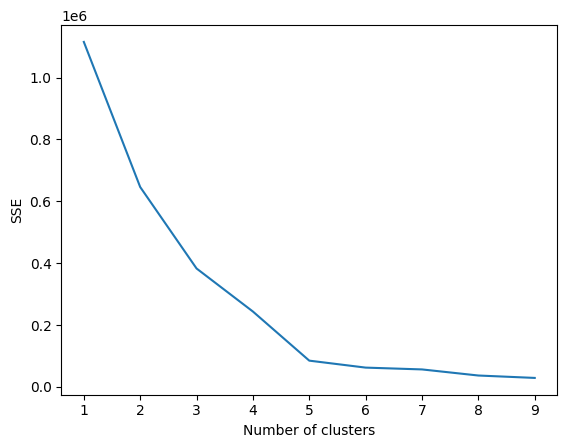

In [7]:
# Elbow criterion method

data = reduced_df.copy()
OMP_NUM_THREADS=2 #prevents data leakage on Windows

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")

In [8]:
# Silhouette coefficient method
from sklearn.metrics import silhouette_score

# Set variables
X = reduced_df.copy()
y = TARGET_VAR
clusters = []

# Test a range of clusters for their silhouette coefficients
for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    clusters.append({'n_clusters': n_cluster, 'coefficient': sil_coeff})

# Select the maximum coefficient
clusters = pd.DataFrame(clusters)
c = clusters.iloc[clusters["coefficient"].argmax()]["n_clusters"]
s = clusters["coefficient"].max()
n = int(c)

print("{} clusters returns a maximum Silhouette Coefficient of {}".format(n, s))

5 clusters returns a maximum Silhouette Coefficient of 0.8207353353500366


Use the suggested optimal number of clusters ():

In [9]:
cluster = KMeans(
    n_clusters=n,
    random_state=RANDOM_SEED
)

clust_df = reduced_df.copy()
clust_df["Cluster"] = cluster.fit_predict(clust_df.values)
clust_df["Cluster"] = clust_df["Cluster"].astype(str)

# Add ID columns
clust_df[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

clust_df.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
clust_df.head()

,Component 1,Component 2,Component 3,Cluster,taxon_id,media_id
0,15.552606,11.062140,-5.814806,2,103836,J104
1,0.684297,22.511497,9.303279,3,76637,J28
2,16.807875,-9.751039,2.702453,4,589240,J104
3,7.432455,9.199549,21.868313,0,1036778,1a
4,19.662439,11.384926,14.668433,0,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


#### Visualize the results

In [26]:
fig = px.scatter_3d(
    data_frame=clust_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color = "Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white",
    opacity=0.05
)

fig.update_traces(marker={'size': 6})
fig.show()

#### Create new column from clusters

In [11]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([2, 3, 4, ..., 0, 3, 3])

### Classifier

In [12]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Metrics

In [13]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       541
           1       0.99      0.96      0.98       375
           2       1.00      0.95      0.97       314
           3       0.82      0.91      0.86       109
           4       0.99      0.96      0.98       105

    accuracy                           0.96      1444
   macro avg       0.95      0.95      0.95      1444
weighted avg       0.96      0.96      0.96      1444



In [14]:
# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves

from sklearn import metrics

roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.972165256418878


#### Feature Importances

In [15]:
import xgboost
import shap

# train an XGBoost model
model2 = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model2)
shap_values = explainer(X_train)

shap.plots.initjs()

In [16]:
# visualize all the training set predictions
#shap.plots.force(shap_values[:1000])

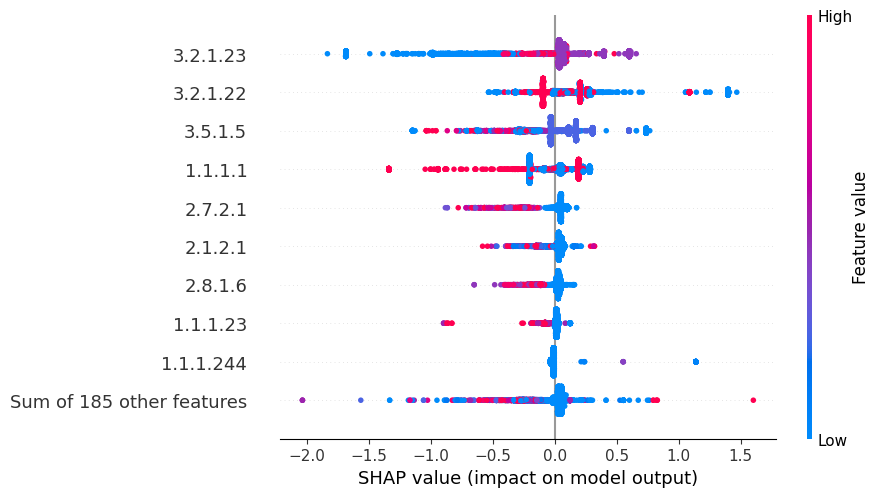

In [17]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)